# Beschreibung des Codes zur Objekterkennung und Segmentierung mit Mask R-CNN

In diesem Beispiel verwenden wir das vortrainierte **Mask R-CNN Modell** aus `torchvision`, um Objekte zu erkennen und ihre Segmentierungs-Masken auf einem Bild zu zeichnen.

## Schritt-für-Schritt Erklärung:

1. **Bild herunterladen**:
   - Wir verwenden die `requests`-Bibliothek, um ein Bild von einer URL herunterzuladen.
   - Das Bild wird anschließend mit der `PIL`-Bibliothek geöffnet.

2. **Bildvorbereitung**:
   - Das heruntergeladene Bild wird mit `torchvision.transforms.ToTensor()` in ein Tensor konvertiert.
   - Ein `unsqueeze(0)` wird angewendet, um das Bild auf eine Batch-Dimension zu bringen (wichtig für die Eingabe in das Modell).

3. **Laden des Modells**:
   - Wir laden das **Mask R-CNN Modell** (`maskrcnn_resnet50_fpn`) aus `torchvision.models.detection`. Dieses Modell gibt nicht nur die Bounding Boxes, sondern auch die **Masken** für die Objekte zurück.
   - Das Modell wird in den Evaluierungsmodus (`model.eval()`) versetzt.

4. **Durchführen der Inferenz**:
   - Die Inferenz erfolgt ohne Gradientenberechnung (`torch.no_grad()`), um die Berechnungen zu optimieren.
   - Das Modell gibt eine Reihe von Vorhersagen zurück, einschließlich der Bounding Boxes, Masken und Scores der erkannten Objekte.

5. **Verarbeitung der Vorhersagen**:
   - Die Bounding Boxes werden aus den Vorhersagen extrahiert und in `long` konvertiert, um sie im Bild zeichnen zu können.
   - Die Masken werden durch einen Schwellenwert (0.7) gefiltert, um nur die relevanten Masken anzuzeigen.
   
6. **Zeichnen der Bounding Boxes und Masken**:
   - Mit `torchvision.utils.draw_bounding_boxes` zeichnen wir die Bounding Boxes der erkannten Objekte.
   - Mit `torchvision.utils.draw_segmentation_masks` zeichnen wir die Segmentierungsmasken für jedes erkannte Objekt.

7. **Bild anzeigen**:
   - Das Bild mit den Bounding Boxes und Masken wird schließlich mit `matplotlib` angezeigt.


C:\Users\julia\PycharmProjects\MAVIS\.env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\julia/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:28<00:00, 6.34MB/s]


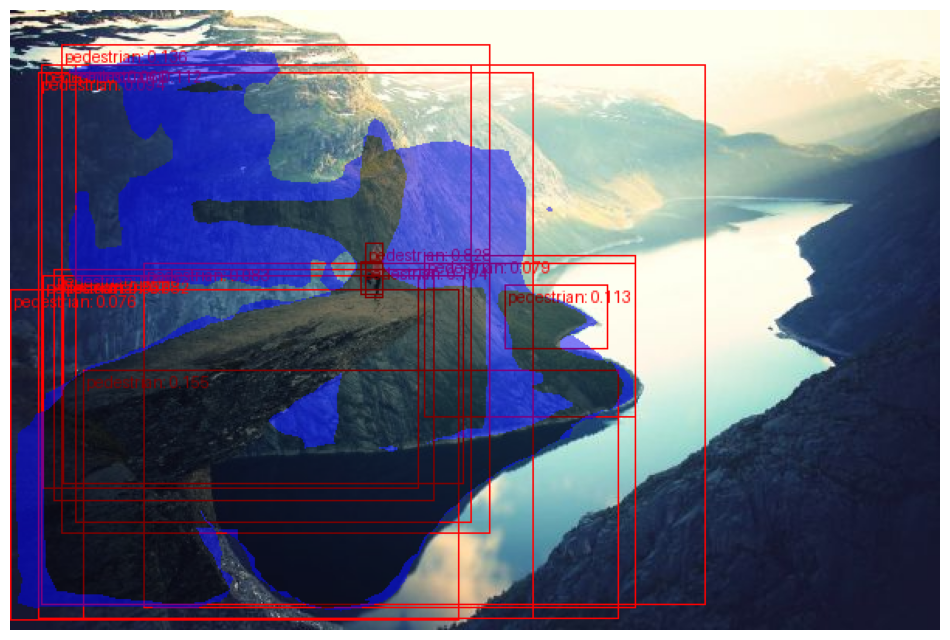

In [15]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image
import requests
from io import BytesIO
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Bild von der URL herunterladen
url_image = "https://www.w3schools.com/w3images/fjords.jpg"
response = requests.get(url_image)
img = Image.open(BytesIO(response.content))

# Bild in ein Tensor umwandeln und normalisieren
transform = transforms.Compose([
    transforms.ToTensor(),  # Umwandlung von PIL zu Tensor
])

image = transform(img).unsqueeze(0)  # Unsqueeze für das Batch-Dimension (1, C, H, W)

# Vortrainiertes Mask R-CNN Modell laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)
model.eval()

# Inferenz durchführen
with torch.no_grad():
    image = image.to(device)
    predictions = model(image)
    pred = predictions[0]

# Das Bild in den Bereich [0, 255] umwandeln und auf uint8 setzen
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image.squeeze(0)  # Entfernen der Batch-Dimension

# Labels und Boxen vorbereiten
pred_labels = [f"pedestrian: {score:.3f}" for score in pred["scores"]]
pred_boxes = pred["boxes"].long()

# Bounding Boxes auf das Bild zeichnen
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# Masken für die Segmentierung zeichnen
masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Ausgabe des Bildes mit Bounding Boxes und Segmentierungen
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))  # Umordnen von (C, H, W) zu (H, W, C)
plt.axis('off')  # Achsen ausschalten
plt.show()
